In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np


import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project


ROOT_DIR = os.path.abspath("../..")

In [2]:
# Import Mask RCNN
sys.path.append(ROOT_DIR)
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

from samples.face import face

%matplotlib inline

/home/jho/anaconda3/envs/mask/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jho/anaconda3/envs/mask/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jho/anaconda3/envs/mask/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jho/anaconda3/envs/mask/lib/python3.6/site-packages/ten

In [3]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Notebook Preferences

In [4]:
def get_ax(rows=1, cols=1, size=8):
    """
    Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default isze attribute to control the size
    of rendered images
    """
    
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax


## Configurations

Configurations are defined in face.py

In [5]:
config = face.FaceConfig()
FACE_DIR = os.path.join(ROOT_DIR, "samples/face/face_data")


### Validation Dataset

In [8]:
# Validation dataset
dataset_val = face.FaceDataset()
dataset_val.load_face(FACE_DIR, 'val')
dataset_val.prepare()

print("Image Count: {}".format(len(dataset_val.image_ids)))
print("Class Count: {}".format(dataset_val.num_classes))
for i, info in enumerate(dataset_val.class_info):
    print("{:3}. {:50}".format(i, info['name']))


Loading images: 100%|██████████| 355/355 [00:00<00:00, 729.51it/s]

Image Count: 355
Class Count: 2
  0. BG                                                
  1. face                                              


## Detection

In [15]:
class InferenceConfig(face.FaceConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()
# model_path = os.path.join(MODEL_DIR, "face20200407T2202/mask_rcnn_face_0000.h5")

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/jho/projects/Mask_RCNN/logs/face20200408T1803/mask_rcnn_face_0099.h5
Re-starting from epoch 99


original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max:  256.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:   55.00000  max:  226.00000  int32
gt_mask                  shape: (256, 256, 1)         min:    0.00000  max:    1.00000  bool


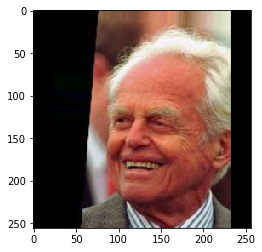

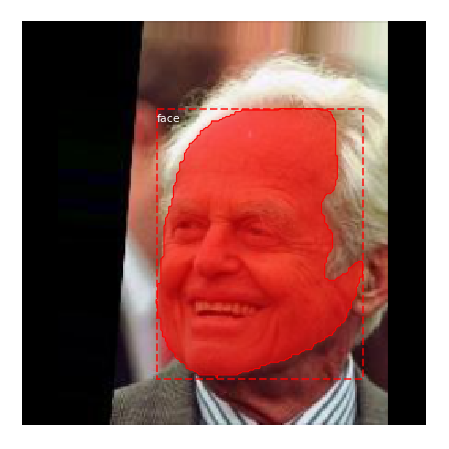

In [16]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)
plt.imshow(original_image)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_val.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  float64
anchors                  shape: (1, 16368, 4)         min:   -1.41976  max:    2.16878  float32


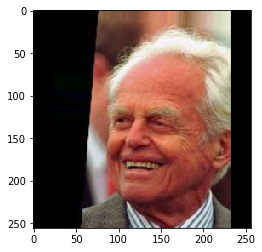

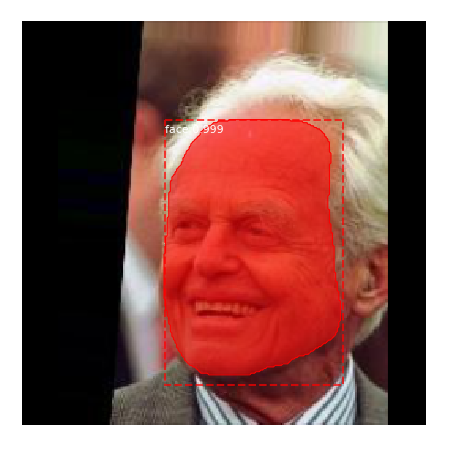

In [17]:
plt.imshow(original_image)

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [18]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  1.0
